# Building & experimenting with predictive modelling based on virtual reference transcripts.

#### The following code provides a general overview of the experimental design I used to explore the use of NLP algorithms to develop predictive models.  Due to privacy concerns the original data and full model implementation is unavailable to the general public.  This effectively limits others' abillity to replicate my results, but given the sensitivity of the underlying data, this is a necessary limitation.

#### In brief, the models rely on techniques such as TF-IDF metrics, LDA, DOC2VEC, and Ontological Modelling to inform how texts are processed, modelled, and used to make predictions about users engagement with library services.

#### Ultimately, the goal of the modelling process is to be able to predict if the first few words a patron utters in a virtual reference environment can predict the relative difficulty (based on READ scale ratings) of the overall interaction.

#### If the model(s) can be shown to be effective in predicting targetted dependent variables, then this approach could hypothetically be incorporated into perscriptive mode that enables libraries to effectively triage incoming virtual reference interactions based on difficutly, question-type, or other targetted outcomes.

## (1) Import requisite packages, libraries, and data

In [1]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neural_network import MLPClassifier

%env PYTHONHASHSEED=1
%matplotlib inline
import tqdm as tqdm

from gensim.models import Doc2Vec, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import strip_punctuation, strip_short, strip_non_alphanum
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_multiple_whitespaces, remove_stopwords
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from gensim.matutils import corpus2dense

C:\Users\jw\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
rawData = pd.read_json('full.json')
rawData.shape

(14900, 34)

In [3]:
rawData['Start Date'] =  pd.to_datetime(rawData['Start Date'],unit='ms')
rawData['End Date'] =  pd.to_datetime(rawData['End Date'],unit='ms')

In [4]:
rawData = rawData[rawData['segCode']==0]
rawData.shape

(14607, 34)

In [5]:
rawData = rawData.sort_index()

In [6]:
rawData = rawData.sort_values(by='Start Date')

In [7]:
rawData.dtypes

Id                                       int64
Start Date                      datetime64[ns]
Start Time                              object
End Date                        datetime64[ns]
End Time                                object
Duration                                object
Entered by                              object
Notes                                   object
Question                                object
Answer                                  object
Notes FULL                              object
Library Dept./Branch/Service            object
Where were you?                         object
Who answers                             object
Who Asked?                              object
How many in the group?                  object
Question Format                         object
Question Type                           object
Referred to?                            object
READ                                    object
Time Spent                              object
Class/Discipl

## (2) Define mapping of regex expressions to ontological nodes

In [8]:
manualTags = [
    ['tagURL',[
        re.escape('amazon.com'),
        re.escape('newfirstsearch'),
        re.escape('galegroup'),
        re.escape('ingentaconnect.com'),
        re.escape('proquest.com'),
        re.escape('ncbi.nlm.nih.gov'),
        re.escape('sciencedirect.com'),
        re.escape('springer.com'),
        re.escape('tandfonline.com'),
        re.escape('webofknowledge'),
        re.escape('wiley.com'),
        re.escape('books.google'),
        re.escape('google.com'),

        re.escape('apps.lib.k-state.edu/databases'),

        re.escape('er.lib.ksu.edu'),
        re.escape('er.lib.k-state.edu'),

        re.escape('getit.lib.ksu.edu'),
        re.escape('getit.lib.k-state.edu'),

        re.escape('guides.lib.ksu.edu'),
        re.escape('guides.lib.k-state.edu'),

        re.escape('catalog.lib.ksu.edu'),
        re.escape('catalog2.lib.ksu.edu'),
        re.escape('catalog.lib.k-state.edu'),
        re.escape('catalog2.lib.k-state.edu'),

        re.escape('primo.hosted.exlibrisgroup.com'),
        re.escape('na02.alma.exlibrisgroup'),

        re.escape('searchit.lib.ksu.edu'),
        re.escape('searchit.lib.k-state.edu'),

        re.escape('lib.k-state.edu'),

        re.escape('doi.org'),

        re.escape('http'),
        re.escape('www.'),]
    ],
    
    ['tagPRINTING',[
        'color print',
        'colored print',
        'print in color',
        'print something in color',
        "\Win color\W",
        "cat cash",
        'printer',
        '(?<!3D\s)\bprinting',
        'double.{1}sided',
        'catcash',
        'cat cash',
        'add money',]
    ],    
    
    ['tagSCANNER',[
        'scanner',
        '\Wscan\W',]
    ],      
    
    ['tagHOURS',[
        'open 24/7',
        'what time',
        'the hours',
        'opens{0,1}\W',
        'will be open',
        'summer hours',
        'library hours',]
    ],    
    
    
    ['tagLIBMATHPHYS',[
        re.escape('Math/Physics Library'),
        re.escape('math and physics library'),
        re.escape('Math Physic library'),
        re.escape('math/physics library'),
        re.escape('maths/phys library'),
        re.escape('math & phys library'),
        re.escape('math phys library'),]
    ],
    
    ['tagLIBWEIGEL',[
        'weigel',
        'wiegel',]
    ],
    
    ['tagLIBVETMED',[
        'vet med',
        'vetmed',]
    ],
    
    ['tagLIBHALE',[
        'Hale Library',
        "(?<!help\s)hale",]
    ],
    
    ['tagLIBSTACKS',[
        'Library Stacks',
        'the stacks',
        'in Stacks',]
    ],
    
    ['tagTEXTBOOKS',[
        'the reserve',
        'on reserve',
        'course reserve',
        'reserve textbook',
        'have a specific textbook',
        'have the textbook',
        'have textbook',
        'this textbook',
        'this text book',]
    ],
    
    ['tagQUIET',[
        'quite loud',
        'super loud',
        'really loud',
        'very loud',
        'stop talking',
        'talking on',
        'music loud',
        "loud",
        "talking very",
        "talking extremely",
        "talking loud",
        'quiet floor',
        '"quiet" floor',
        'Quiet Zone',
        'quiet floors',
        'floor to be quiet',
        'whisper quietly',
        'be quiet',
        'floor to be quiet',]
    ],
    
    
    ['tagLIBLOCATION',[
        'first floor',
        '1st floor',
        'second floor',
        '2nd floor',
        'third floor',
        '3rd floor',
        'fourth floor',
        '4t floor',
        'fifth floor',
        '5th floor',
        'hemisphere room',
        'Harry Potter room',
        'the hemi',]
    ],
    
    ['tagARTICLES',[
        "peer.{,1}review",
        'journal article',
        'scholarly article',
        'scholarly journal',
        '"scholarly article',
        'peer reviewed',
        re.escape('peer-reviewed'),
        'peerreviewed',
        'scholarly',
        'articles',]
    ],
    
    ['tagEVIDENCEBASED',[
        "evidence.based",
        "kinesiology",]
    ],
    
    ['tagJUVENILE',[
        "juv lit section",
        "Juvenile Literature",
        re.escape("juv. lit"),
        "children'{0,1}s collection",
        "children'{0,1}s lit",
        "children'{0,1}s stor",
        re.escape("children's boooks"),
        "(?<!Germany on English )children'{0,1}s book",
        re.escape("children's picture"),
        "picture book",]
    ],
    
    
    ['tagCURRICULUM',[
        "curriculum materials",
        "curriculum books",]
    ],
    
    
    ['tagKNOWNITEMARTICLE',[
        "doi\W\s{,1}\S+",
        "doi:{0,1}\s{0,1}\d\S+",
        "this article",
        "this\s\w+\sarticle",
        'this paper',
        'doi\.\S+',
        'doi:{0,1}\s{0,1}\d\S+',
        'doi\.org\S+',]
    ],
    
    
    ['tagKNOWNITEMBOOK',[
        "[a-z]{1,2}\d{2,4}\s{0,1}\.[a-z]\d{1,}",
        'this book',]
    ],
    
    
    
    ['tagREFERENCE',[
        "articles{0,1}\sabout",
        "books{0,1}\sabout",
        "subject",
        "topic",
        "a paper on",
        "help me find an{0,1}"]
    ],
    
    
]

rollupTags = [
    ['tagEASY',[
        'tagKNOWNITEMBOOK',
        'tagLIBHALE',
        'tagLIBLOCATION',
        'tagLIBMATHPHYS',
        'tagLIBSTACKS',
        'tagLIBWEIGEL',
        'tagOPEN',
        'tagPRINTING',
        'tagQUIET',
        'tagSCANNER',
        'tagTEXTBOOKS',]
    ],
    
    ['tagHARD',[
        'tagARTICLES',
        'tagCURRICULUM',
        'tagEVIDENCEBASED',
        'tagJUVENILE',
        'tagKNOWNITEMARTICLE',
        'tagREFERENCE',
        'tagURL',]
    ],
]

## (3) Define modular functions for processing, modelling, and predicting data

#### Iterate through texts and ontology nodes, and annotate individual transcripts with any tags present within predefined sections of text strings

In [9]:
def getManualTags(df,collectTags,manualTagsList,section,rollups):
    st = time.time()
    
    df = df.copy()
    df['manualTags'] = [[] for i in range(df.shape[0])] 
    
    if collectTags == True:
        taglist = pd.Series()
        for i in df.index:
            tags = []
            for k in manualTagsList:
                if k[0] in tags:
                    continue
                for m in k[1]:
                    if re.search(pattern=m,flags=re.IGNORECASE,string=df.loc[i,section]):
                        tags.append(k[0])                
            if rollups == True:
                for n in rollupTags:
                    if n[0] in tags:
                        continue
                    for o in n[1]:
                        if o in tags:
                            tags.append(n[0])
            tags = list(np.unique(tags))
            taglist.loc[i] = tags
        df.loc[taglist.index,'manualTags'] = taglist
    
    et = time.time() - st
    print('{:.2f} : Getting Manual Tags'.format(et))
    if rollups:
        print('Including Rollup Tags')
    return(df)

#### Split patron-generated strings into three separate subsets; each of varying space-delimited lengths.  This is applied to all testing and training data, but can be easily applied to each subset distinctly.

In [10]:
def getPatronSections(df,breaks):
    st = time.time()
    
    df = df.copy()
    corpus = df['PatronTextString'].str.split(pat="\s{1,}").copy()
    
    for i in corpus.index:
        df.loc[i,'PatronText_A'] = " ".join(corpus.loc[i][:breaks[0]])
        df.loc[i,'PatronText_B'] = " ".join(corpus.loc[i][:breaks[1]])
        df.loc[i,'PatronText_C'] = " ".join(corpus.loc[i][:breaks[2]])
    
    et = time.time() - st
    print('{:.2f} : Splitting Patron Lines'.format(et))    
    return(df)        

#### Tokenize text strings

In [11]:
def getTextsTokens(df,corpus,model):
    st = time.time()
    
    corpus = corpus.copy()
    df = df.copy()
    CUSTOM_FILTERS = [lambda x: x.lower(),
                  strip_multiple_whitespaces,
#                   strip_non_alphanum,
#                   strip_short,
                 ]
    
    tokenizedTexts = [preprocess_string(x, CUSTOM_FILTERS) for x in corpus]
    tokenizedTexts = pd.Series(tokenizedTexts,index=corpus.index)
    
    gensim_dictionary = Dictionary(tokenizedTexts)
    
    et = time.time() - st
    print('{:.2f} : Tokenizing Texts'.format(et))
    return(tokenizedTexts,gensim_dictionary)

#### If appropriate, reduce the vocabulary size of the dataset according to document-frequency and TF-IDF cutoffs

In [12]:
def getTFIDFlimited(df, section, truncate, controlVocab, model):
    st = time.time()
    df = df.copy()
    texts = df.loc[:,section].copy()
    
    fullVocab = CountVectorizer().fit(texts).get_feature_names()
    
    if truncate[0] == True:
        count = CountVectorizer(
            token_pattern=r"(?u)\b\w{3,}\b",
            min_df=truncate[1],
        )
    else:
        count = CountVectorizer(
            token_pattern=r"(?u)\b\w{1,}\b",
        )
        
    countDF = pd.DataFrame(count.fit_transform(texts).todense(),
                           index=df.index,
                           columns=count.get_feature_names())
    tfidf = TfidfTransformer()
    tfidfDF = pd.DataFrame(tfidf.fit_transform(countDF).todense(),
                           index=df.index,
                           columns=count.get_feature_names())    
    countList = countDF.sum().sort_values(ascending=False)
    tfidfList = tfidfDF.mean().sort_values(ascending=False)
    
    
    if truncate[0] == True:
#         vocab = list(set(countList.index[:truncate[2]]).union(set(tfidfList.index[:truncate[2]])))
        vocab = list(tfidfList.index[:truncate[2]])
        remove = list(set(count.get_feature_names()) ^ set(fullVocab))
        
    else:
        vocab = list(set(countList.index).union(set(tfidfList.index)))
        remove = list(set(count.get_feature_names()) ^ set(fullVocab))
        
    vocab = vocab + controlVocab
    vocab = set(list(np.unique(vocab)))
        
    newTexts = pd.Series()
    for i in texts.index:
        k = re.split(string=texts.loc[i],pattern="\W")
        j = []
        for m in k:
            if m in vocab:
                j.append(m)

        newTexts.loc[i] = " ".join(j)
    
    tokenizedTexts,gendict = getTextsTokens(df=df,corpus=newTexts,model=model)    
    
    df.loc[newTexts.index,'filteredTexts'] = newTexts
    df.loc[tokenizedTexts.index,'tokenizedTexts'] = tokenizedTexts
    
    et = time.time() - st
    print('{:.2f} : Truncating by TFIDF, maybe'.format(et))              
    return(df,countDF,countList,tfidfList,remove,vocab,gendict)

#### Train LDA model and return LDA-transformed data

In [13]:
def getLDAmatrix(df,dictionary,collectTags,random):
    st = time.time()
    
    rand = random
    %set_env PYTHONHASHSEED=rand
    df = df.copy()
    tokenizedTexts = list(df['tokenizedTexts'])
        
    tokenizedList_bow = [dictionary.doc2bow(x) for x in tokenizedTexts]
    
    ntop = 75
    iterations = 100
    
    ldaModel = LdaModel(
        corpus=tokenizedList_bow,
        id2word=dictionary, 
        num_topics=ntop, 
        random_state=rand,
        chunksize=2000,
#         passes=5,
        update_every=1,
        alpha=1/ntop,
        eta=1/ntop, 
        decay=0.7,
        offset=1.0, 
        eval_every=100, 
        iterations=iterations, 
        gamma_threshold=0.001,
        minimum_probability=0.01,
        minimum_phi_value=0.01
    )
    
    
    ldaDocMatrix = [i for i in ldaModel.get_document_topics(tokenizedList_bow)]
    ldaDF = pd.DataFrame(corpus2dense(ldaDocMatrix, num_terms=ldaModel.num_topics).transpose(), index=df.index)
    
    if collectTags:
        counter = CountVectorizer(binary=True)

        tagstrings = df['manualTags'].str.join(" ")    
        tagDF = pd.DataFrame(counter.fit_transform(tagstrings).todense(),
                             columns=counter.get_feature_names(),
                             index=df.index)

        ldacolumntags = counter.get_feature_names()
        ldaDF = ldaDF.merge(tagDF,left_index=True,right_index=True,suffixes=(False,False))
    else:
        ldacolumntags = None
    
    et = time.time() - st
    print('{:.2f} : Getting LDA Model / DF'.format(et))
    return(ldaModel, ldaDF, ldacolumntags)

#### Train Doc2Vec model and return inferred document vectors for training data

In [14]:
def doc2vecModel(df,collectTags,random):
    st = time.time()
    df = df.copy()
    
    rand = random
    
    documentsTrain = [TaggedDocument(df.loc[i,'tokenizedTexts'], (
        [str(df.loc[i,'Id'])]+df.loc[i,'manualTags'])) for i in df.index]
    
    iterations = 100
    
    %set_env PYTHONHASHSEED=rand
    model = Doc2Vec(
        documentsTrain,
        dm=0,
        dbow_words=1,
        vector_size=75, 
        window=5, 
        min_count=1, 
        workers=1,
        seed=rand,
        epocs=iterations,
        hs=1,
        negative=0
               )
    
    indic = []
    dat = []
    for i in df.index:
        indic.append(i)
        dat.append(model.infer_vector((df.loc[i,'tokenizedTexts']+df.loc[i,'manualTags']), steps=iterations))
        
    vectorDF = pd.DataFrame(dat,index=indic)
    
#     if collectTags:
#         counter = CountVectorizer(binary=True)
#         tagstrings = df['manualTags'].str.join(" ")    
#         tagDF = pd.DataFrame(counter.fit_transform(tagstrings).todense(),
#                              columns=counter.get_feature_names(),
#                              index=indic)
#         d2vcolumntags = counter.get_feature_names()
#         vectorDF = vectorDF.merge(tagDF,left_index=True,right_index=True,suffixes=(False,False))
#     else:
#         d2vcolumntags = None
        
    d2vcolumntags = None
    
    et = time.time() - st
    print('{:.2f} : Getting D2V Model / DF'.format(et))
    return(model, vectorDF,d2vcolumntags)    

#### Use LDA or Doc2Vec data representations as the input layer of a neural network classifier with only 1 hidden layer containing 10 nodes.  Model classification is intended to predict if the first few words from a patron are indicative of an "Easy" vs "Hard" virtual reference interaction.  The performance metric for the model is ROC-AUC.

In [15]:
def trainModel(df,reps,targetLabels,random,tagState):
    st = time.time()
    df = df.copy()
    reps = reps
    rand = random
    
    labels = df.loc[df[targetLabels]!=999,targetLabels].astype(int).copy()
    
    indices = labels.index
    X = reps.loc[indices,:]
    y = labels
    
    neural_model = MLPClassifier(hidden_layer_sizes=(10,),max_iter=100,random_state=rand)
    neural_model.fit(X,y)
    yprob = neural_model.predict_proba(X)[:,1]
    yprob_pred = neural_model.predict(X)
    RocAucScore = roc_auc_score(y_true=y,y_score=yprob)
    
    
    listIndex = []
    notIndex = []
    if tagState:
        for i in df.loc[labels.index,].index:
            if len(df.loc[i,'manualTags']) > 0:
                listIndex.append(int(i))
            else:
                notIndex.append(int(i))
    
        Xlist = representation.loc[listIndex,:]
        y_prob_list = neural_model.predict_proba(Xlist)[:,1]
        yprob_pred_list = neural_model.predict(Xlist)        
        
        RocAucScore_list = roc_auc_score(y_true=labels.loc[listIndex],y_score=y_prob_list)
        df.loc[listIndex,'PredictProbList'] = y_prob_list
        df.loc[listIndex,'PredictPredList'] = yprob_pred_list

        
        
        Xlist = representation.loc[notIndex,:]
        y_prob_list = neural_model.predict_proba(Xlist)[:,1]
        yprob_pred_list = neural_model.predict(Xlist)
        
        RocAucScore_NOTlist = roc_auc_score(y_true=labels.loc[notIndex],y_score=y_prob_list)
        df.loc[notIndex,'PredictProbNOTList'] = y_prob_list
        df.loc[notIndex,'PredictPredNOTList'] = yprob_pred_list
    
    else:
        RocAucScore_list = RocAucScore
        RocAucScore_NOTlist = RocAucScore
        df.loc[labels.index,'PredictProbList'] = yprob
        df.loc[labels.index,'PredictPredList'] = yprob_pred
    
    
    df.loc[labels.index,'PredictProb'] = yprob
    df.loc[labels.index,'PredictPred'] = yprob_pred
    
    et = time.time() - st
    print('{:.2f} : Running MLP Fit and Eval'.format(et))
    return(neural_model,RocAucScore,RocAucScore_list,RocAucScore_NOTlist,len(listIndex),len(notIndex),df)

#### Process and tokenize the targetted Patron substring from testing/external data

In [16]:
def prepareTestingData(df,vocab,section):
    st = time.time()    
    df = df.copy() 
    
    splitStrings = df.loc[:,section].str.lower()
    splitStrings = splitStrings.str.split("\W")
    
    testTokens = pd.Series()
    for i in splitStrings.index:
        j = []
        for m in splitStrings.loc[i]:
            if m in vocab:
                j.append(m)

        testTokens.loc[i] = j
    df.loc[testTokens.index,'tokenizedTexts'] = testTokens
    
    
    et = time.time() - st
    print('{:.2f} : Preparing Test Holdout Data'.format(et))
    return(df)

#### Generate predictions using out-of-sample testing data following LDA/Doc2Vec transformations.

In [17]:
def testModel(df,targetLabels,modelType,dictionary,neural_model,collectTags,joincolumns,tagState):
    st = time.time()    
    df = df.copy()
    
    labels = df.loc[df[targetLabels]!=999,targetLabels].astype(int).copy()
    df_test = df.loc[labels.index,].copy()
    
    if modelType == 'lda':
        tokenizedTexts = list(df_test['tokenizedTexts'])
        tokenizedList_bow = [dictionary.doc2bow(x) for x in tokenizedTexts]
        ldaDocMatrix = [i for i in ldaModel.get_document_topics(tokenizedList_bow)]
        representation = pd.DataFrame(corpus2dense(ldaDocMatrix, num_terms=ldaModel.num_topics).transpose(), index=df_test.index)
        
        if collectTags:
            counter = CountVectorizer(vocabulary=joincolumns,binary=True)
            tagstrings = df_test['manualTags'].str.join(" ")
            tagDF = pd.DataFrame(counter.fit_transform(tagstrings).todense(),
                                 columns=joincolumns,
                                 index=df_test.index)
            representation = representation.merge(tagDF,left_index=True,right_index=True,suffixes=(False,False))

            
    if modelType == 'd2v':
        indic = []
        dat = []
        for i in df_test.index:
            indic.append(i)
            dat.append(d2vModel.infer_vector((df_test.loc[i,'tokenizedTexts']+df_test.loc[i,'manualTags']), steps=100))
        representation = pd.DataFrame(dat,index=indic)
    
    
    
    X = representation
    yTest_prob = neural_model.predict_proba(X)[:,1]
    yTest_pred = neural_model.predict(X)
    RocAucScore = roc_auc_score(y_true=labels,y_score=yTest_prob)
    
    listIndex = []
    notIndex = []
    if tagState:
        for i in df.loc[labels.index,].index:
            if len(df.loc[i,'manualTags']) > 0:
                listIndex.append(int(i))
            else:
                notIndex.append(int(i))
    
        Xlist = representation.loc[listIndex,:]
        y_prob_list = neural_model.predict_proba(Xlist)[:,1]
        yprob_pred_list = neural_model.predict(Xlist)        
        
        RocAucScore_list = roc_auc_score(y_true=labels.loc[listIndex],y_score=y_prob_list)
        df.loc[listIndex,'PredictProbList'] = y_prob_list
        df.loc[listIndex,'PredictPredList'] = yprob_pred_list

        
        
        Xlist = representation.loc[notIndex,:]
        y_prob_list = neural_model.predict_proba(Xlist)[:,1]
        yprob_pred_list = neural_model.predict(Xlist)
        
        RocAucScore_NOTlist = roc_auc_score(y_true=labels.loc[notIndex],y_score=y_prob_list)
        df.loc[notIndex,'PredictProbNOTList'] = y_prob_list
        df.loc[notIndex,'PredictPredNOTList'] = yprob_pred_list
    
    
    else:
        RocAucScore_list = RocAucScore
        RocAucScore_NOTlist = RocAucScore
        df.loc[labels.index,'PredictProbList'] = yTest_prob
        df.loc[labels.index,'PredictPredList'] = yTest_pred
    
    
    df.loc[labels.index,'PredictProb'] = yTest_prob
    df.loc[labels.index,'PredictPred'] = yTest_pred
    
    et = time.time() - st
    print('{:.2f} : Testing Model with Holdout Data'.format(et))
    return(RocAucScore,RocAucScore_list,RocAucScore_NOTlist,len(listIndex),len(notIndex),df)
    

#### Generate performance metrics for subsets of training and testing data in which individual samples were detected as containing regex expressions relevant to the 'manualTags' and ontology nodes

In [18]:
def getFocusedROCAUC(df_test,df_train,qtype,labelledsection,tagState):
    st = time.time()
    df_test = df_test.copy()
    df_train = df_train.copy()
    
    df_train = df_train.loc[df_train['READ']!='Unknown',]
    ytrue = df_train.loc[df_train['Question Type']==qtype,labelledSection]
    ypred = df_train.loc[df_train['Question Type']==qtype,'PredictProb']
    trainRocAucScore = roc_auc_score(y_true=ytrue,y_score=ypred)
    
    df_test = df_test.loc[df_test['READ']!='Unknown',]
    ytrue = df_test.loc[df_test['Question Type']==qtype,labelledSection]
    ypred = df_test.loc[df_test['Question Type']==qtype,'PredictProb']
    testRocAucScore = roc_auc_score(y_true=ytrue,y_score=ypred)
    
    if tagState:
        trainList = []
        for i in df_train.index:
            if len(df_train.loc[i,'manualTags']) > 0:
                trainList.append(i)
        testList = []
        for i in df_test.index:
            if len(df_test.loc[i,'manualTags']) > 0:
                trainList.append(i)
                

        df_train_list = df_train.loc[trainList,].copy()
        ytrue_list = df_train_list.loc[df_train_list['Question Type']==qtype,labelledSection]
        ypred_list = df_train_list.loc[df_train_list['Question Type']==qtype,'PredictProbList']
        try:
            trainRocAucScore_list = roc_auc_score(y_true=ytrue_list,y_score=ypred_list)
        except:
            ypred_list = df_train_list.loc[df_train_list['Question Type']==qtype,'PredictPred']
            trainRocAucScore_list = "Acc_" + str(accuracy_score(y_true=ytrue_list,y_pred=ypred_list))


        df_test_list = df_test.loc[testList,].copy()
        ytrue_list = df_test_list.loc[df_test_list['Question Type']==qtype,labelledSection]
        ypred_list = df_test_list.loc[df_test_list['Question Type']==qtype,'PredictProbList']
        try:
            testRocAucScore_list = roc_auc_score(y_true=ytrue_list,y_pred=ypred_list)
        except:
            ypred_list = df_test_list.loc[df_test_list['Question Type']==qtype,'PredictPredList']
            testRocAucScore_list = "Acc_" + str(accuracy_score(y_true=ytrue_list,y_pred=ypred_list))
        trainListShape = len(trainList)
        testListShape = len(testList)

        
    else:
        trainRocAucScore_list = None
        testRocAucScore_list = None
        trainListShape = 0
        testListShape = 0
    
    
    et = time.time() - st
    print('{:.2f} : Getting Focused ROC-AUC Scores ({})'.format(et,qtype))
    return(trainRocAucScore,testRocAucScore,trainRocAucScore_list,testRocAucScore_list,trainListShape,testListShape)

## (4) Establish experimental design for exploring and validating modelling processes 

#### The following represent the parameters of the experimental design.  The following code is configured so that only a single model is trained and evaluated.  Enabling or extending the options for each of the parameters will effectively conduct a Grid-Search across all possible parameter combinations.

In [19]:
# custom vocab builder; only use if specific words need to be retained
customVocab = []

# random states; use to re-run models to confirm convergence and inference
randomOptions = [42]

# single value, define the quantity for train/test split within dataset
testingSplits = [
    2000,
]

# include or exclude manualTagging and ontological logic from model
manualTagOptions = [
    True,
#     False,
]

# include ontology super-classes in model
rollupsOptions = [
    True,
#     False,
]

# options defining how to trim and truncate vocabulary
# ( conditionState , min doc freq , words to retain )
truncateOptions = [    
#     (False, 1, 30000),
#     (True, 2, 1000),
#     (True, 2, 1500),
#     (True, 2, 2000),
#     (True, 2, 2500),
    (True, 2, 3000),
#     (True, 3, 1000),
#     (True, 3, 1500),
#     (True, 3, 2000),
#     (True, 3, 2500),
#     (True, 3, 3000),
#     (True, 4, 1000),
#     (True, 4, 1500),
#     (True, 4, 2000),
#     (True, 4, 2500),
#     (True, 4, 3000),
]

# patron segmentations; [tokenLength,tokenLength,tokenLength]
patronSegmentsOptions = [
    [5,10,20],
]

# defines which patronSegmentsOptions sections to include in modelling
patronSectionOptions = [
#     'PatronText_A',
#     'PatronText_B',
    'PatronText_C',
]

# defines READ split for dependent classification variable
labelledSectionOptions = [
#     'READ_1_vs_2',
    'READ_2_vs_3',
]

# options for which learning models are used for representation
modelOptions = [
#     'lda',
    'd2v',
]

# total combination of modelling formulations
optionsList = [
    randomOptions,
    manualTagOptions,
    rollupsOptions,
    patronSegmentsOptions,
    truncateOptions,
    patronSectionOptions,
    labelledSectionOptions,
    modelOptions,
]

optionsLen = [len(x) for x in optionsList]

testtotal = np.prod(optionsLen)
iterationcounter = 0

parameterList = []

#### The following code represents the sequences through which every possible modelling formulation is trained and evaluated.  In this notebook, only a single model formulation was run.  However, if multiple model formulations are tested, the output will provide useful comparisons between respective models' performance metrics.

In [20]:
for z in tqdm.tqdm(randomOptions):
    randomSeed=z

    for a in patronSegmentsOptions:
        patronSegments=a
        dataSEG = getPatronSections(df=rawData,breaks=patronSegments)

        for b in testingSplits:
            split = b
            testsplit = dataSEG.shape[0]-split
            trainData = dataSEG[:testsplit]
            testData = dataSEG[testsplit:]

            for c in patronSectionOptions:
                patronSection=c 

                for d in manualTagOptions:
                    getTags = d
                    
                    for e in rollupsOptions:
                        if getTags == True:
                            rollup = e
                        elif getTags == False:
                            if e == True:
                                continue
                        trainDataTagged = getManualTags(df=trainData,
                                                        collectTags=getTags,
                                                        manualTagsList=manualTags,
                                                        section=patronSection,
                                                        rollups=rollup,
                                                       )
                        testDataTagged = getManualTags(df=testData,
                                                       collectTags=getTags,
                                                       manualTagsList=manualTags,
                                                       section=patronSection,
                                                       rollups=rollup,
                                                      )

                        for f in labelledSectionOptions:
                            labelledSection = f

                            for g in modelOptions:
                                model = g              

                                for h in truncateOptions:
                                    truncate = h 

                                    start_time = time.time()

                                    trainDataTRUNC,countDF,countList,tfidfList,remove,vocab,gendict = getTFIDFlimited(
                                        df=trainDataTagged,
                                        truncate=truncate,
                                        section=patronSection,
                                        controlVocab=customVocab,
                                        model=model,
                                    )

                                    if model == 'lda':
                                        ldaModel, representation, columntags = getLDAmatrix(
                                            df=trainDataTRUNC,
                                            dictionary=gendict,
                                            collectTags=getTags,
                                            random=randomSeed)



                                    if model == 'd2v':
                                        d2vModel, representation, columntags = doc2vecModel(
                                            df=trainDataTRUNC,
                                            collectTags=getTags,
                                            random=randomSeed)


                                    MLPmodel,AUCscore,AUCscorelist,AUCscoreNOTlist,trainLlen,trainNLlen,trainDataFinal = trainModel(
                                        df=trainDataTRUNC,
                                        reps=representation,
                                        targetLabels=labelledSection,
                                        random=randomSeed,
                                        tagState=getTags,)


                                    testDataPrepped = prepareTestingData(
                                        df=testDataTagged,
                                        vocab=vocab,
                                        section=patronSection,)


                                    testAUC,testAUClist,testAUCNOTlist,testLlen,testNLlen,testDataFinal = testModel(
                                        df=testDataPrepped,
                                        targetLabels=labelledSection,
                                        modelType=model,
                                        dictionary=gendict,
                                        neural_model=MLPmodel,
                                        joincolumns=columntags,
                                        collectTags=getTags,
                                        tagState=getTags,)



                                    end_time = time.time()
                                    total_time = end_time-start_time

                                    modelParameters = {
                                        
                                        'ManualTags':getTags,
                                        'RollupTags':rollup,
                                        'Truncation':str(truncate),
                                        'PSsegmentations':str(patronSegments),
                                        'PStargetsection':patronSection,
                                        'Labels':labelledSection,
                                        'ModelAbstraction':model,
                                        'AUCtrain':AUCscore,
                                        'AUCtest':testAUC,
                                        
                                        'AUCtrain_Listed':AUCscorelist,
                                        'AUCtest_Listed':testAUClist,
                                        'AUCtrain_Not_Listed':AUCscoreNOTlist,
                                        'AUCtest_Not_Listed':testAUCNOTlist,
                                        
                                        'AUCtrain_ListedLEN':trainLlen,
                                        'AUCtrain_ListedNLEN':trainNLlen,
                                        'AUCtest_ListedLEN':testLlen,
                                        'AUCtest_ListedNLEN':testNLlen,
                                        
                                        'CycleTime':total_time,
                                        'RandomSeeds':randomSeed,
                                        'Custom Vocab Len':len(customVocab),
                                        'Full Vocab Len':len(vocab),
                                        'Testing Split':testsplit,
                                        'Training Data Full':trainData.shape[0],
                                        'Testing Data Full':testData.shape[0],
                                        'Training Data Final':trainDataFinal.shape[0],
                                        'Testing Data Final':testDataFinal.shape[0],
                                                      }

                                    parameterList.append(list(modelParameters.values()))
                                    print(modelParameters.values())
                                    iterationcounter += 1
                                    print("{} out of {} complete".format(iterationcounter,testtotal))

parameterDataFrame = pd.DataFrame(parameterList,columns=list(modelParameters.keys()))

  0%|          | 0/1 [00:00<?, ?it/s]

29.42 : Splitting Patron Lines
23.15 : Getting Manual Tags
Including Rollup Tags
3.39 : Getting Manual Tags
Including Rollup Tags
0.22 : Tokenizing Texts
11.77 : Truncating by TFIDF, maybe
env: PYTHONHASHSEED=rand
15.47 : Getting D2V Model / DF


C:\Users\jw\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.83 : Running MLP Fit and Eval
1.17 : Preparing Test Holdout Data
1.92 : Testing Model with Holdout Data
dict_values([True, True, '(True, 2, 3000)', '[5, 10, 20]', 'PatronText_C', 'READ_2_vs_3', 'd2v', 0.7470237712041716, 0.6949404906721683, 0.7641812623714689, 0.7518362900715841, 0.7388857449145323, 0.6580910563560406, 3034, 7130, 548, 1205, 32.246846437454224, 42, 0, 3000, 12607, 12607, 2000, 12607, 2000])
1 out of 1 complete


100%|██████████| 1/1 [01:28<00:00, 88.24s/it]


## (5) Explore Model Performance
#### In this case, the model I am exploring is one in which Doc2Vec was used to abstract and represent 'documents' as represented by patron-strings

In [21]:
# define dependent variable of interest
READ = labelledSectionOptions[0]

### Using cosine-similarity, it is very easy to use GENSIM and Scikit-Learn to evaluate how closely aligned any given document vector is to another vector.

### In this instance, we can explore if an indivual reference transcript that is quite obviously a 'noise complaint' is closely aligned with the document-vector generated for the Ontology node (manualTag) 'tagQUIET'.

In [22]:
print(testDataFinal.loc[9062,'PatronText_C'])

Hi there, I know it's not considered a quiet zone, but there is a man on the east stairs that


In [23]:
similarityDF = pd.DataFrame(columns=['tagQUIET','tagREFERENCE','tagARTICLE','tagEASY','tagHARD'])
similarityDF.index.name = 'Inference Steps'

for i in range(20):
    inf = d2vModel.infer_vector(testDataFinal.loc[9062,'tokenizedTexts'], steps=i)
    tagquiet = [inf,d2vModel['tagQUIET']]
    tagreference = [inf,d2vModel['tagREFERENCE']]
    tagarticle = [inf,d2vModel['tagKNOWNITEMARTICLE']]
    tageasy = [inf,d2vModel['tagEASY']]
    taghard = [inf,d2vModel['tagHARD']]
    
    similarityDF.loc[i,'tagQUIET'] = cosine_similarity(tagquiet)[0,1]
    similarityDF.loc[i,'tagREFERENCE'] = cosine_similarity(tagreference)[0,1]
    similarityDF.loc[i,'tagARTICLE'] = cosine_similarity(tagarticle)[0,1]
    similarityDF.loc[i,'tagEASY'] = cosine_similarity(tageasy)[0,1]
    similarityDF.loc[i,'tagHARD'] = cosine_similarity(taghard)[0,1]

#### With each additional inference step, the 'noise complaint' document's vector very rapidly aligns (i.e. becomes more similar to) with the vector for 'tagQUIET' and 'tagEASY' while remaining relatively unaligned with other known vectors.  This is just one example that demonstrates that the model is performing and representing data in ways that we expected.

In [24]:
similarityDF

,tagQUIET,tagREFERENCE,tagARTICLE,tagEASY,tagHARD
Inference Steps,,,,,
0,0.160182,0.0717911,0.0463951,0.121786,0.000784038
1,0.762117,-0.158386,-0.124503,0.41223,-0.129895
2,0.761154,-0.121226,-0.10005,0.457687,-0.0978988
3,0.766664,-0.113936,-0.0796777,0.492037,-0.101509
4,0.780748,-0.131194,-0.0920018,0.481536,-0.124201
5,0.781754,-0.112938,-0.0728496,0.480581,-0.0997775
6,0.789788,-0.0867832,-0.0501579,0.527053,-0.0761226
7,0.772944,-0.0883329,-0.045616,0.503436,-0.0642551
8,0.807654,-0.096905,-0.0720465,0.492823,-0.0825251


### Basic visualizations also provide useful mechanisms for understanding how well a specific model classifies and discriminates between targetted dependent variables.

#### In an ideal world, this model would perfectly separate the 'Easy' from 'Hard' virtual reference interactions and the produce the following idealized distributions of predicted classes

In [25]:
x0norm = np.random.normal(loc=0.2,scale=0.075,size=1000)
x1norm = np.random.normal(loc=0.8,scale=0.075,size=1000)

In [26]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 5})

In [27]:
def plotDistributions(x0,x1,plotTitle,cut0=None,cut1=None):
    plt.figure(figsize=(12,8))
    ax = sns.distplot(x0, hist=False, label='EASY : {}'.format(len(x0)), kde_kws={"shade": True})
    ax = sns.distplot(x1, hist=False, label='HARD : {}'.format(len(x1)), kde_kws={"shade": True})
    ax.set(xlabel='Predicted Probability', ylabel='Density', title=plotTitle)
    ax.set(xlim=(0,1))
    
    if cut0:
        plt.axvline(x=f1.idxmax(), color='green', linestyle='dashdot')
    if cut1:
        plt.axvline(x=acc.idxmax(), color='red', linestyle='dashdot')
   
    plt.legend(loc='best')
    plt.show()

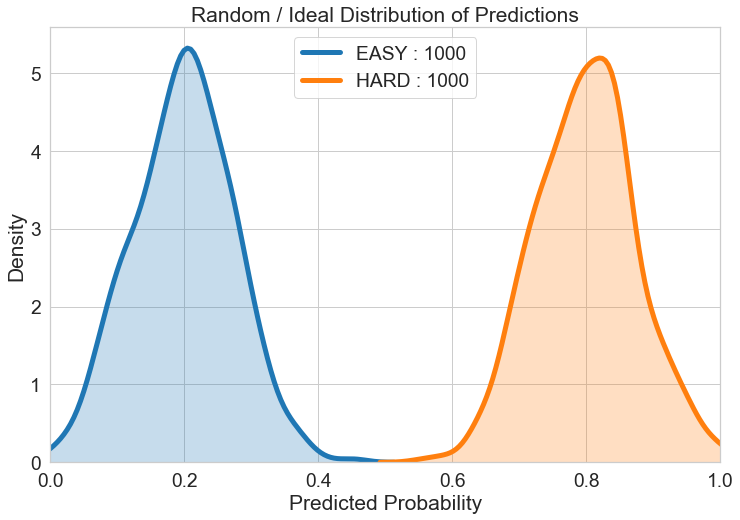

In [28]:
plotDistributions(x0=x0norm,x1=x1norm,plotTitle='Random / Ideal Distribution of Predictions')

#### However, in practice, NLP data is much more difficult to work with and the relatively small size of this dataset means the model is far from perfect. In the following plot, the distribution of predictions for respective classes is based purely on the training (in-sample) data.

In [29]:
x0train = trainDataFinal.loc[trainDataFinal[READ]==0,['PredictProb']]
x1train = trainDataFinal.loc[trainDataFinal[READ]==1,['PredictProb']]

xprob = trainDataFinal.loc[trainDataFinal[READ]!=999,['PredictProb']]
xpred = trainDataFinal.loc[trainDataFinal[READ]!=999,['PredictPred']]

y = trainDataFinal.loc[trainDataFinal[READ]!=999,[READ]]

In [30]:
cuts = list(np.arange(0.01,1.00,.01))

acc = pd.Series()
f1 = pd.Series()
roc_auc = roc_auc_score(y_score=xprob, y_true=y)

for i in cuts:
    x = np.where(trainDataFinal.loc[trainDataFinal[READ]!=999,'PredictProb'] >= i,1,0)
    acc.loc[i] = accuracy_score(y_pred=x,y_true=y)
    f1.loc[i] = f1_score(y_pred=x,y_true=y)

C:\Users\jw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

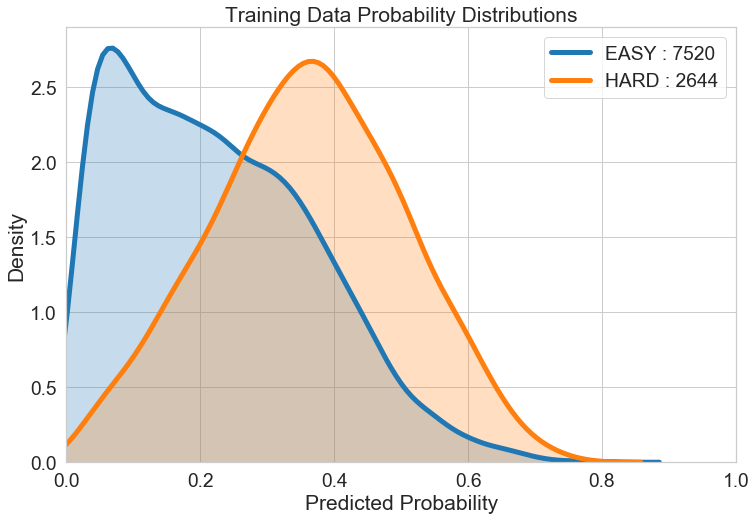

In [31]:
plotDistributions(x0=x0train,x1=x1train,plotTitle='Training Data Probability Distributions',cut0=None,cut1=None)

#### In addition to distributions, we can identify where the 'optimal' cutoff is for class predictions based on simple metrics like accuracy and F1 scores.  Ultimately, the exact cutoff that is appropriate is highly sensitive to both the underlying dataset AND the strategic business objectives of the institution implementing the model

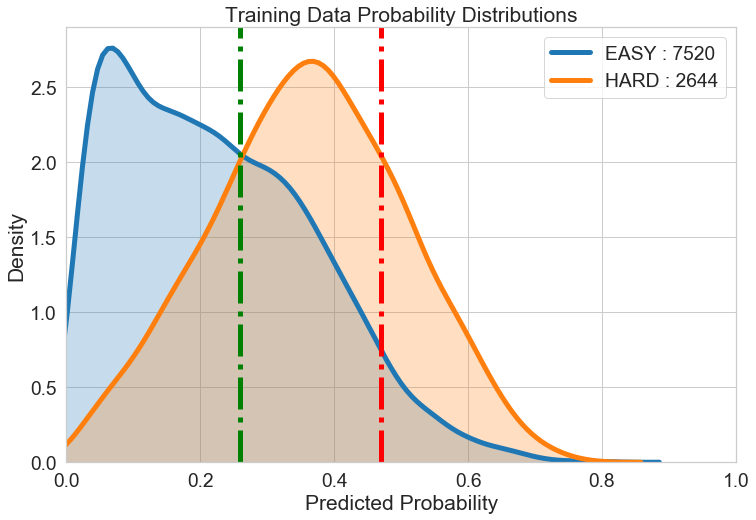

In [32]:
plotDistributions(x0=x0train,x1=x1train,plotTitle='Training Data Probability Distributions',cut0=f1.idxmax(),cut1=acc.idxmax())

In [33]:
print("ROC AUC Score : {:.4f}".format(roc_auc))
print("F1 Score ({:.4f}) at Cutoff ({:.4f})".format(f1.max(),f1.idxmax()))
print("Accuracy Score ({:.4f}) at Cutoff ({:.4f})".format(acc.max(),acc.idxmax()))

ROC AUC Score : 0.7470
F1 Score (0.5286) at Cutoff (0.2600)
Accuracy Score (0.7573) at Cutoff (0.4700)


### Using the optimal F1 cutoff for the training data, we can also evaluate predictive accuracy for the whole testing dataset and targetted subsets of the testing data.

In [34]:
primarycut = f1.idxmax()

In [35]:
primarycut

0.26

#### For all of the testing data, we can see that the predicted distributions are relatively similar to that of the training data.  Additionally, using the optimal cutoff from the training data, we can predict the F1 score and classification accuracy for the testing data.

In [36]:
x1test = testDataFinal.loc[testDataFinal[READ]==1,['PredictProb']]
x0test = testDataFinal.loc[testDataFinal[READ]==0,['PredictProb']]

xprob = testDataFinal.loc[testDataFinal[READ]!=999,['PredictProb']]
xpred = testDataFinal.loc[testDataFinal[READ]!=999,['PredictPred']]

y = testDataFinal.loc[testDataFinal[READ]!=999,[READ]]

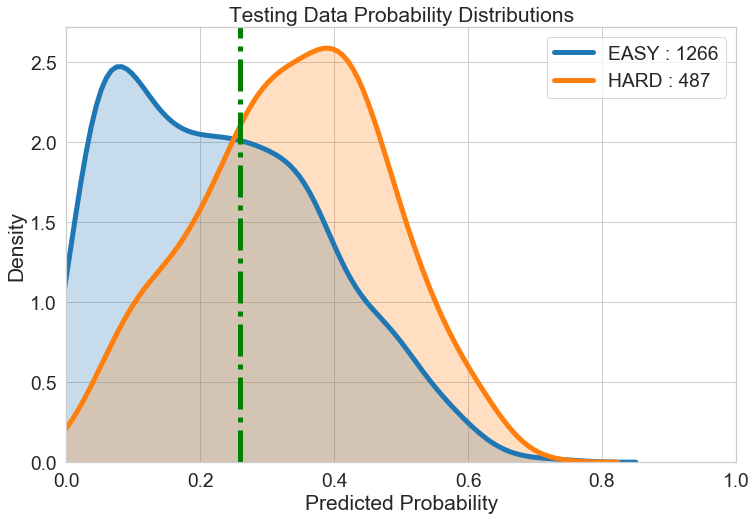

In [37]:
plotDistributions(x0=x0test,x1=x1test,plotTitle='Testing Data Probability Distributions',cut0=primarycut)

In [38]:
x = np.where(testDataFinal.loc[testDataFinal[READ]!=999,'PredictProb'] >= primarycut,1,0)
accList = accuracy_score(y_pred=x,y_true=y)
f1List = f1_score(y_pred=x,y_true=y)
roc_auc = roc_auc_score(y_score=xprob, y_true=y)

print("ROC AUC Score : {:.4f}".format(roc_auc))
print("F1 Score ({:.4f}) at Cutoff ({:.4f})".format(f1List,primarycut))
print("Accuracy Score ({:.4f}) at Cutoff ({:.4f})".format(accList,primarycut))

ROC AUC Score : 0.6949
F1 Score (0.5126) at Cutoff (0.2600)
Accuracy Score (0.6235) at Cutoff (0.2600)


#### Lastly, we can identify specific samples from the testing data which contain the regex expressions defined by the 'manualTags' and ontology structure.  Based on the current model formulation, the inputs from these test samples were not annotated as part of processing, so the only data being processed in the model are the string-tokens from the raw texts.

#### In this case, only transcripts that would qualify to be tagged as 'printing', 'noise complaint', or 'reference' questions are targetted and focused on in the plot.  Since most librarians would agree that these question-types should skew towards opposites ends of the READ scale, any practical NLP model should be discriminate between these questions relatively well.

In [39]:
listIndex = []
notIndex = []
tags = [
    'tagQUIET',
    'tagPRINTING',
    'tagREFERENCE'
]

for i in testDataFinal.loc[testDataFinal[READ]!=999,'manualTags'].index:
    for k in tags:
        if k in testDataFinal.loc[i,'manualTags']:
            listIndex.append(i)

listIndex = list(set(listIndex).intersection(set(testDataFinal.index)))

In [40]:
listDF = testDataFinal.loc[listIndex,].copy()
x0list = listDF.loc[listDF[READ]==0,['PredictProb']]
x1list = listDF.loc[listDF[READ]==1,['PredictProb']]

xproblist = listDF.loc[listDF[READ]!=999,['PredictProb']]
xpredlist = listDF.loc[listDF[READ]!=999,['PredictPred']]

ylist = listDF.loc[listDF[READ]!=999,[READ]]

In [41]:
x = np.where(listDF.loc[listDF[READ]!=999,'PredictProb'] >= primarycut,1,0)
accList = accuracy_score(y_pred=x,y_true=ylist)
f1List = f1_score(y_pred=x,y_true=ylist)
roc_auc = roc_auc_score(y_score=xproblist, y_true=ylist)

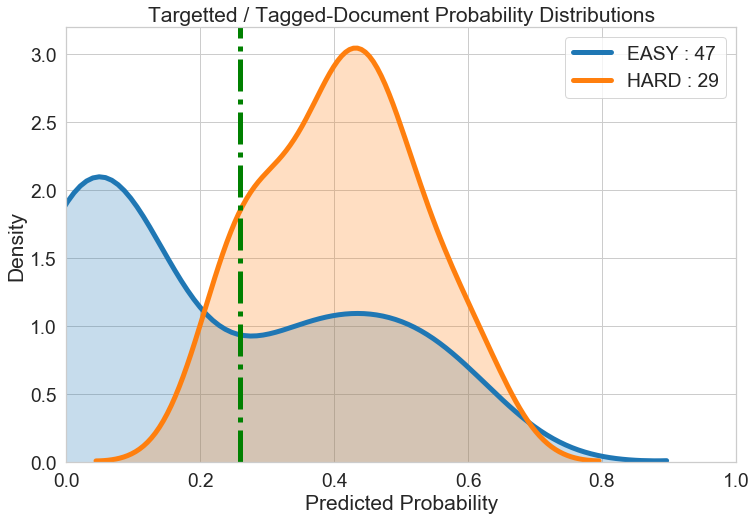

In [42]:
plotDistributions(x0=x0list,x1=x1list,plotTitle='Targetted / Tagged-Document Probability Distributions',cut0=primarycut)

In [43]:
print("ROC AUC Score : {:.4f}".format(roc_auc))
print("F1 Score ({:.4f}) at Cutoff ({:.4f})".format(f1List,primarycut))
print("Accuracy Score ({:.4f}) at Cutoff ({:.4f})".format(accList,primarycut))

ROC AUC Score : 0.7557
F1 Score (0.6849) at Cutoff (0.2600)
Accuracy Score (0.6974) at Cutoff (0.2600)


## (6) Concluding notes
#### Based on the plot above, it is is apparent that although the model is not perfect, it is effective at discriminating between subsets of data in intuitive ways.
#### The overall processes demonstrated in this code have the potential to be implemented into virtual reference services as a prescriptive model.  Depending on the specific strategic goals of platform hosts or institutional managers, this model could be used to triage incoming virtual reference inquiries according the predicted nature of the overall reference interaction.
#### Although this model is functional and could potentially be incorporated in a production-environment, I would strong advise against using the model parameters demonstrated here without more exhaustive testing and parameter tuning.